In [7]:
import sys
import os
import math
from math import pi
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.fftpack import fft, ifft
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import firwin2,welch
from scipy.signal import spectrogram

In [8]:
def fftfilt(b, x):
    """Use FFT to apply FIR filter defined by b to signal x."""
    # 获取输入信号和滤波器的长度
    N_x = len(x)
    N_b = len(b)
    
    # 计算 FFT 的大小
    N = N_x + N_b - 1
    
    # 计算滤波器和输入信号的 FFT
    X = np.fft.fft(x, N)
    B = np.fft.fft(b, N)
    
    # 乘以滤波器的频率响应
    Y = X * B
    
    # 计算逆 FFT 以获得滤波后的信号
    y = np.fft.ifft(Y)
    
    # 取出中间的部分，与输入信号长度相同
    start = (N_b - 1) // 2
    y = y[start:start + N_x]
    
    # 只取实部（虚部应该非常接近零）
    return np.real(y)

def stat_gauss_noise(n_samp,freq,PSD,flt_ord,samp_freq):
    sqrt_PSD=np.sqrt(PSD)
    sqrt_PSD[-1]=0
    #b=firwin2(flt_ord,freq/(samp_freq/2),sqrt_PSD)
    b=firwin2(flt_ord,freq/(samp_freq/2),sqrt_PSD)
    in_noise=np.random.randn(1,n_samp)
    
    # print(in_noise.shape,b.shape)
    # print(fftfilt(b,in_noise[0]).shape)
    return np.sqrt(samp_freq)*fftfilt(b,in_noise[0])
def inner_prod(x,y,samp_freq,PSD):
    n_samp=len(x)
    if len(x)!=len(y):
        return "Vectors must have the same length"
    k_Nyq=math.floor(n_samp/2)+1
    
    if len(PSD)!=k_Nyq:
        return "PSD values must be specified at positive DFT frequencies"
    fftX=fft(x)
    fftY=fft(y)
    neg_freq=1-n_samp%2
    PSD_4norm=np.append(PSD,PSD[(k_Nyq-neg_freq-2)::-1])
    
    data_len=samp_freq*n_samp
    
    return (1/data_len*(np.conj(fftX)/PSD_4norm)@(fftY.reshape(-1,1))).real
def signal(t,snr,coeff):
    phi=t*coeff[0]+coeff[1]*t**2+coeff[2]*t**3
    signal=np.sin(2*pi*phi)
    norm=np.sqrt(sum(signal*signal))
    return snr*signal/norm

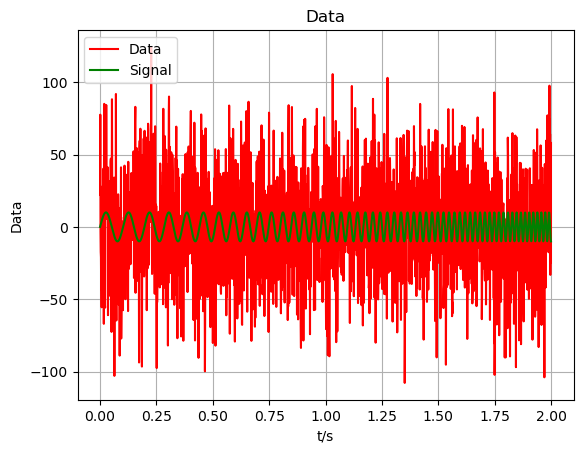

In [9]:
n_samp=2048
samp_freq=1024
time_vec=1/samp_freq*np.arange(0,n_samp,1)

def noise_PSD(f):
    out=np.zeros(len(f))
    for i in range(0,len(f)):
        if (100 <= f[i]) and (f[i]<= 300):
            out[i]=(f[i] - 100) * (300 - f[i]) / 10000+1
        else:
            out[i]=1
    return out

data_Len = n_samp/samp_freq
k_Nyq = math.floor(n_samp/2)+1
pos_freq = (1/data_Len)*np.arange(0,k_Nyq)
PSD_pos_freq = noise_PSD(pos_freq)

a1=9.5
a2=2.8
a3=3.2
A=10

snr=10

sig=signal(time_vec,A,np.array([a1,a2,a3]))
norm_sig=inner_prod(sig,sig,samp_freq,PSD_pos_freq)
#print(norm_sig)
sig=snr*sig/np.sqrt(norm_sig)
noise=stat_gauss_noise(n_samp,pos_freq,PSD_pos_freq,100,samp_freq)

data=sig+noise

plt.plot(time_vec,data,'r',label="Data")
plt.plot(time_vec,sig,'g',label="Signal")
plt.grid(True)
plt.xlabel("t/s")
plt.ylabel("Data")
plt.legend(loc='upper left')
plt.title("Data")
plt.show()

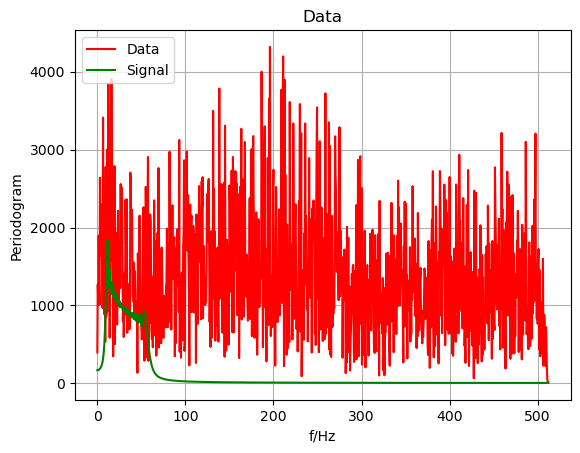

In [10]:
data_fft=np.abs(fft(data))
sig_fft=np.abs(fft(sig))
plt.plot(pos_freq,data_fft[:k_Nyq],'r',label="Data")
plt.plot(pos_freq,sig_fft[:k_Nyq],'g',label="Signal")
plt.grid(True)
plt.xlabel("f/Hz")
plt.ylabel("Periodogram")
plt.legend(loc='upper left')
plt.title("Data")
plt.show()

In [12]:
win_len_samp=64
ovrlp_samp=60
f,T,S=spectrogram(sig,samp_freq,'hamming',nperseg=win_len_samp,noverlap=ovrlp_samp,nfft=None)